# Classification KNN 6133 Тюгаев Никита Павлович

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from ucimlrepo import fetch_ucirepo

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)


import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

#### 1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [2]:
automobile = fetch_ucirepo(id=10)

df = pd.concat([automobile.data.features, automobile.data.targets], axis=1).replace(
    "?", np.nan
)

variable_info = automobile.variables.drop(
    columns=["role", "demographic", "units", "missing_values"]
)

#### 2. Бинарная классификация:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Закодировать категориальные признаки при необходимости.
   - Выбрать какое-нибудь значение гиперпараметра $k$ алгоритма $kNN$.
   - Разбить выборку на обучающую и тестовую.
     > Разбиение использовать одно и то же для всех последующих манипуляций.
   - Осуществить бинарную классификацию.
   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.
   - Нормализовать данные (`StandardScaler`или `MinMaxScaler`).
   - Осуществить бинарную классификацию.
   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.
   - Сравнить метрики на данных без нормализации и с применением нормализации.
     > Далее используем нормализованные данные.
   - Построить `сorrelation heatmap` и/или воспользоваться методом `corr()`. Выбрать наиболее важные признаки эвристически или на основании каких-нибудь вычислений (***см. [примечание](#примечание)***).
   - Осуществить бинарную классификацию с отфильтрованными признаками.
   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.
   - Сравнить результаты "до" и "после" фильтрации, сделать выводы.
     > Естественно, искомые результаты - улучшение метрик.
   - Перебрать значения гиперпараметра $k$ в каком-нибудь диапазоне с использованием кросс-валидации на данных
     > данных - исходных данных до разбиения с применением нормализации с отфильтрованными признаками. Построить график *train/test accuracy* в зависимости от значения $k$.

##### Привести описание датасета.

**Датасет UCI ML Automobile содержит информацию об автомобилях и их атрибутах, включающими как категориальные признаки (марка, тип топлива, тип кузова), так и числовые характеристики (мощность двигателя, расход топлива, габариты). При использовании страхового риска (symboling) в качестве целевой переменной задача сводится к классификации, где требуется классифицировать уровень риска на основе его технических характеристик и других параметров.**

In [3]:
display(variable_info)

name         type  \
0               price   Continuous   
1         highway-mpg   Continuous   
2            city-mpg   Continuous   
3            peak-rpm   Continuous   
4          horsepower   Continuous   
5   compression-ratio   Continuous   
6              stroke   Continuous   
7                bore   Continuous   
8         fuel-system  Categorical   
9         engine-size   Continuous   
10   num-of-cylinders      Integer   
11        engine-type  Categorical   
12        curb-weight   Continuous   
13             height   Continuous   
14              width   Continuous   
15             length   Continuous   
16         wheel-base   Continuous   
17    engine-location       Binary   
18       drive-wheels  Categorical   
19         body-style  Categorical   
20       num-of-doors      Integer   
21         aspiration       Binary   
22          fuel-type       Binary   
23               make  Categorical   
24  normalized-losses   Continuous   
25          symboling      Integer   

                                          description  
0                       continuous from 5118 to 45400  
1                            continuous from 16 to 54  
2                            continuous from 13 to 49  
3                        continuous from 4150 to 6600  
4                           continuous from 48 to 288  
5                             continuous from 7 to 23  
6                        continuous from 2.07 to 4.17  
7                        continuous from 2.54 to 3.94  
8        1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi  
9                           continuous from 61 to 326  
10         eight, five, four, six, three, twelve, two  
11             dohc, dohcv, l, ohc, ohcf, ohcv, rotor  
12                       continuous from 1488 to 4066  
13                       continuous from 47.8 to 59.8  
14                       continuous from 60.3 to 72.3  
15                     continuous from 141.1 to 208.1  
16                         continuous from 86.6 120.9  
17                                        front, rear  
18                                      4wd, fwd, rwd  
19      hardtop, wagon, sedan, hatchback, convertible  
20                                          four, two  
21                                         std, turbo  
22                                        diesel, gas  
23  alfa-romero, audi, bmw, chevrolet, dodge, hond...  
24                          continuous from 65 to 256  
25                             -3, -2, -1, 0, 1, 2, 3

##### Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".

In [4]:
print("Количество пропущенных значений в каждом столбце:")
display(df.isnull().sum())

Количество пропущенных значений в каждом столбце:


price                 4
highway-mpg           0
city-mpg              0
peak-rpm              2
horsepower            2
compression-ratio     0
stroke                4
bore                  4
fuel-system           0
engine-size           0
num-of-cylinders      0
engine-type           0
curb-weight           0
height                0
width                 0
length                0
wheel-base            0
engine-location       0
drive-wheels          0
body-style            0
num-of-doors          2
aspiration            0
fuel-type             0
make                  0
normalized-losses    41
symboling             0
dtype: int64

In [5]:
categorical_cols = (
    variable_info[variable_info["type"].isin(["Integer", "Categorical", "Binary"])]
    .iloc[:-1]["name"]
    .to_list()
)
numerical_cols = variable_info[variable_info["type"].isin(["Continuous"])][
    "name"
].to_list()

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(
    "Количество пропущенных значений в каждом столбце после заполнения пропущенных значений:"
)
display(df.isnull().sum())

Количество пропущенных значений в каждом столбце после заполнения пропущенных значений:


price                0
highway-mpg          0
city-mpg             0
peak-rpm             0
horsepower           0
compression-ratio    0
stroke               0
bore                 0
fuel-system          0
engine-size          0
num-of-cylinders     0
engine-type          0
curb-weight          0
height               0
width                0
length               0
wheel-base           0
engine-location      0
drive-wheels         0
body-style           0
num-of-doors         0
aspiration           0
fuel-type            0
make                 0
normalized-losses    0
symboling            0
dtype: int64

##### Закодировать категориальные признаки при необходимости.

In [6]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Количество признаков до кодирования: {df.shape[1]}")
print(f"Количество признаков после кодирования: {df_encoded.shape[1]}")

Количество признаков до кодирования: 26
Количество признаков после кодирования: 66


##### Выбрать какое-нибудь значение гиперпараметра $k$ алгоритма $kNN$.

In [7]:
k = 3

model_knn = KNeighborsClassifier(n_neighbors=k)

##### Разбить выборку на обучающую и тестовую.

In [8]:
X = df_encoded.drop("symboling", axis=1)
y_binary = pd.Series(df_encoded["symboling"] > 0).astype(int)

X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.25, random_state=42, stratify=y_binary
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (153, 65)
Размер тестовой выборки: (52, 65)


##### Осуществить бинарную классификацию.

In [9]:
model_knn.fit(X_train, y_train_binary)
y_pred = model_knn.predict(X_test)

##### Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [10]:
def get_classification_metrics(y_true, y_pred, model_name, average):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    report = classification_report(y_true, y_pred, zero_division=0)

    print(f"\nМетрики для модели: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision ({average}): {prec:.4f}")
    print(f"Recall ({average}): {rec:.4f}")
    print(f"F1-score ({average}): {f1:.4f}")
    print("\nClassification Report:")
    print(report)

    return {
        "model_name": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "classification_report": report,
    }

In [11]:
knn_3_metrics = get_classification_metrics(y_test_binary, y_pred, "KNN 3", "binary")


Метрики для модели: KNN 3
Accuracy: 0.6731
Precision (binary): 0.7308
Recall (binary): 0.6552
F1-score (binary): 0.6909

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.70      0.65        23
           1       0.73      0.66      0.69        29

    accuracy                           0.67        52
   macro avg       0.67      0.68      0.67        52
weighted avg       0.68      0.67      0.67        52



##### Нормализовать данные (`StandardScaler`или `MinMaxScaler`).

In [12]:
mm_scaler = MinMaxScaler()

mm_scaled_x_train = pd.DataFrame(
    mm_scaler.fit_transform(X_train), columns=X_train.columns
)
mm_scaled_x_test = pd.DataFrame(mm_scaler.transform(X_test), columns=X_test.columns)

##### Осуществить бинарную классификацию.

In [13]:
model_knn.fit(mm_scaled_x_train, y_train_binary)
y_pred_scaled = model_knn.predict(mm_scaled_x_test)

##### Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [14]:
knn_3_scaled_metrics = get_classification_metrics(
    y_test_binary, y_pred_scaled, "KNN 3 Scaled", "binary"
)


Метрики для модели: KNN 3 Scaled
Accuracy: 0.9231
Precision (binary): 0.9630
Recall (binary): 0.8966
F1-score (binary): 0.9286

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.96      0.90      0.93        29

    accuracy                           0.92        52
   macro avg       0.92      0.93      0.92        52
weighted avg       0.93      0.92      0.92        52



##### Построить `сorrelation heatmap` и/или воспользоваться методом `corr()`. Выбрать наиболее важные признаки эвристически или на основании каких-нибудь вычислений

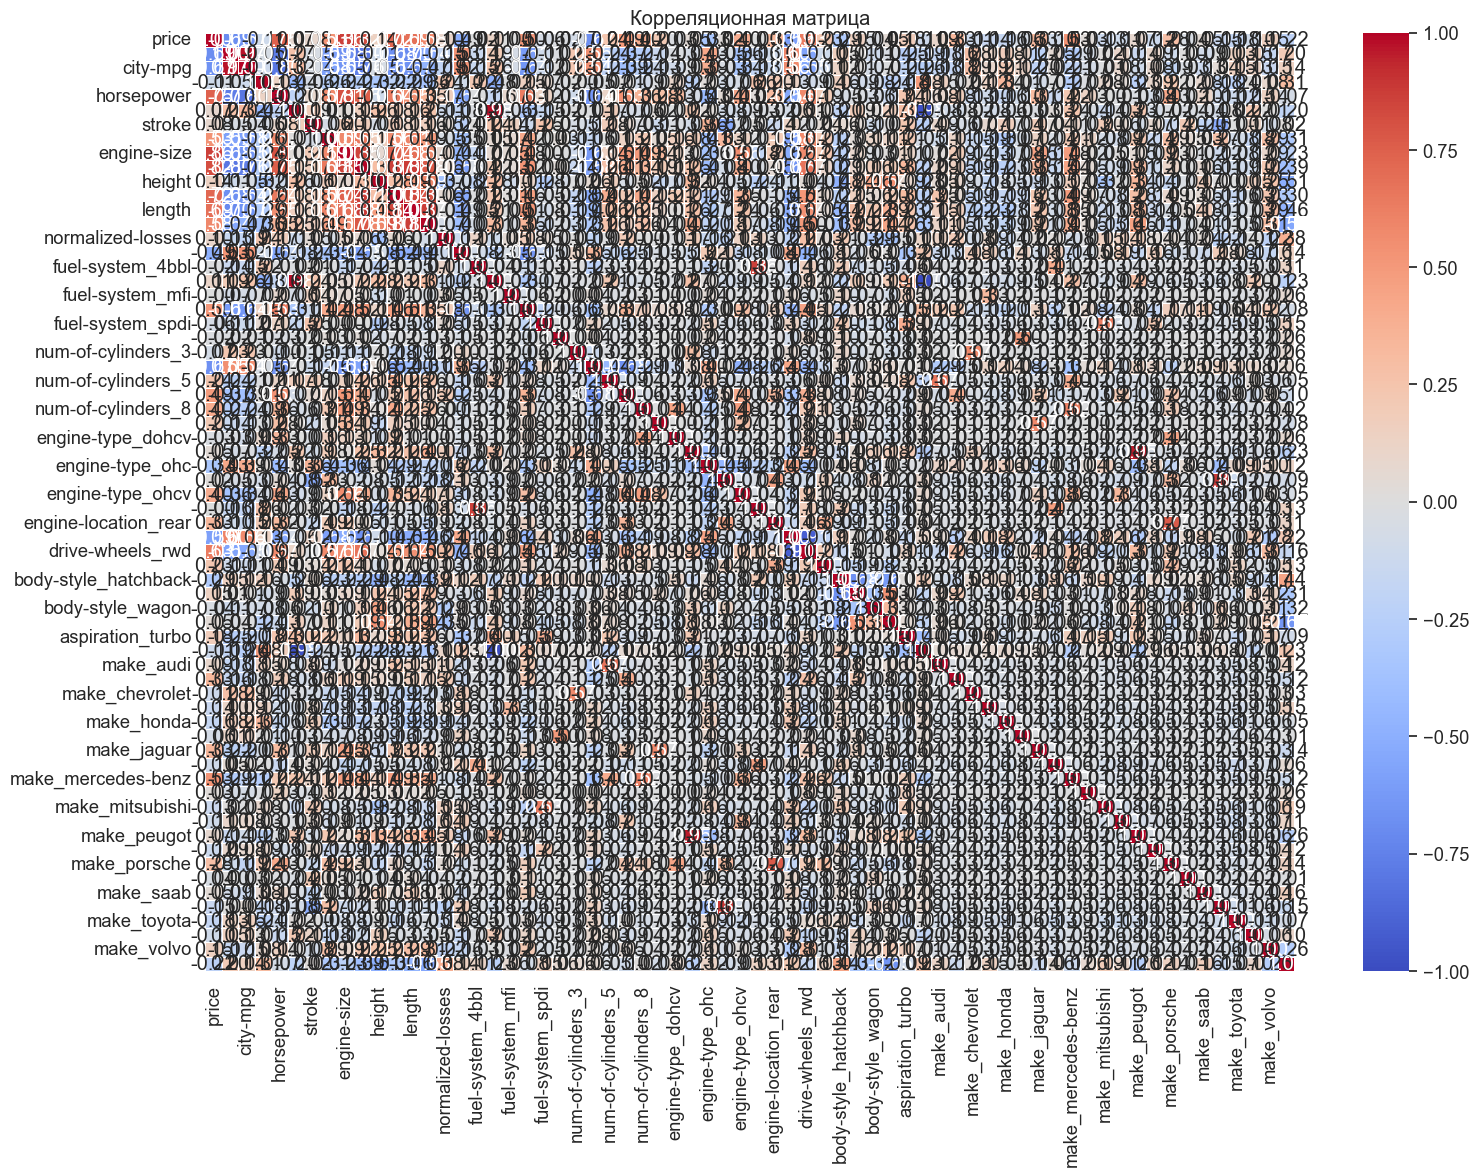

In [15]:
correlation_matrix = pd.concat(
    [
        pd.concat([mm_scaled_x_train, mm_scaled_x_test], axis=0, ignore_index=True),
        pd.concat([y_train_binary, y_test_binary], axis=0, ignore_index=True),
    ],
    axis=1,
).corr()


# Визуализируем корреляционную матрицу

plt.figure(figsize=(16, 12))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Корреляционная матрица")

plt.tight_layout()

plt.show()

In [16]:
target_correlations = correlation_matrix["symboling"].drop("symboling")
print("Корреляция признаков с целевой переменной (модуль):")
pprint(target_correlations.abs().sort_values(ascending=False))

Корреляция признаков с целевой переменной (модуль):
num-of-doors_4.0       0.652
wheel-base             0.548
height                 0.507
length                 0.464
body-style_hatchback   0.443
                        ... 
make_chevrolet         0.028
stroke                 0.020
num-of-cylinders_8     0.016
make_isuzu             0.015
make_renault           0.010
Name: symboling, Length: 65, dtype: float64


In [17]:
correlation_threshold = 0.2
important_features_target = target_correlations[
    abs(target_correlations) > correlation_threshold
].index.tolist()
print(f"\nВажные признаки (корреляция с целевой переменной > {correlation_threshold}):")
print(*important_features_target, sep="\n")
print(f"Количество признаков изначально: {X_train.shape[1]}")
print(f"Количество важных признаков: {len(important_features_target)}")


Важные признаки (корреляция с целевой переменной > 0.2):
price
peak-rpm
bore
engine-size
curb-weight
height
width
length
wheel-base
normalized-losses
fuel-system_idi
engine-type_l
drive-wheels_fwd
body-style_hatchback
body-style_sedan
body-style_wagon
num-of-doors_4.0
fuel-type_gas
make_peugot
make_volvo
Количество признаков изначально: 65
Количество важных признаков: 20


##### Осуществить бинарную классификацию с отфильтрованными признаками.

In [18]:
model_knn.fit(mm_scaled_x_train[important_features_target], y_train_binary)
y_pred_important = model_knn.predict(mm_scaled_x_test[important_features_target])

##### Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [19]:
knn_3_imortant_metrics = get_classification_metrics(
    y_test_binary, y_pred_important, "KNN 3 с отобранными признаками", "binary"
)


Метрики для модели: KNN 3 с отобранными признаками
Accuracy: 0.7692
Precision (binary): 0.9048
Recall (binary): 0.6552
F1-score (binary): 0.7600

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78        23
           1       0.90      0.66      0.76        29

    accuracy                           0.77        52
   macro avg       0.79      0.78      0.77        52
weighted avg       0.80      0.77      0.77        52



##### Сравнить результаты "до" и "после" фильтрации, сделать выводы.

In [20]:
pd.DataFrame(
    [knn_3_metrics, knn_3_scaled_metrics, knn_3_imortant_metrics],
    columns=list(knn_3_metrics.keys()),
).drop("classification_report", axis=1)

model_name  accuracy  precision  recall    f1
0                           KNN 3     0.673      0.731   0.655 0.691
1                    KNN 3 Scaled     0.923      0.963   0.897 0.929
2  KNN 3 с отобранными признаками     0.769      0.905   0.655 0.760

**MinMaxScaler улучшил метрики**\
**Отбор признаков снизил показатели, но все равно лучше, чем до MinMaxScaler**

##### Перебрать значения гиперпараметра $k$ в каком-нибудь диапазоне с использованием кросс-валидации на данных

In [21]:
knn_k_list = range(1, 17)
cv_k = 10
cvgen = StratifiedKFold(cv_k)


for knn_k in tqdm(knn_k_list):
    clf = KNeighborsClassifier(n_neighbors=knn_k)
    scores = cross_val_score(
        clf,
        pd.concat([mm_scaled_x_train, mm_scaled_x_test], axis=0, ignore_index=True)[
            important_features_target
        ],
        pd.concat([y_train_binary, y_test_binary], axis=0, ignore_index=True),
        cv=cvgen,
    )
    print(
        f"Neighbors: {knn_k}, stratified folds count: {cv_k} avg score: {scores.mean()}"
    )

  0%|          | 0/16 [00:00<?, ?it/s]

Neighbors: 1, stratified folds count: 10 avg score: 0.8869047619047619
Neighbors: 2, stratified folds count: 10 avg score: 0.8478571428571428
Neighbors: 3, stratified folds count: 10 avg score: 0.8235714285714286
Neighbors: 4, stratified folds count: 10 avg score: 0.8142857142857143
Neighbors: 5, stratified folds count: 10 avg score: 0.7907142857142857
Neighbors: 6, stratified folds count: 10 avg score: 0.8002380952380952
Neighbors: 7, stratified folds count: 10 avg score: 0.8002380952380953
Neighbors: 8, stratified folds count: 10 avg score: 0.8242857142857144
Neighbors: 9, stratified folds count: 10 avg score: 0.824047619047619
Neighbors: 10, stratified folds count: 10 avg score: 0.8192857142857143
Neighbors: 11, stratified folds count: 10 avg score: 0.78
Neighbors: 12, stratified folds count: 10 avg score: 0.785
Neighbors: 13, stratified folds count: 10 avg score: 0.7897619047619048
Neighbors: 14, stratified folds count: 10 avg score: 0.8145238095238095
Neighbors: 15, stratified fol

##### Построить график train/test accuracy в зависимости от значения $k$

In [22]:
def get_train_test_accuracy_plot(scores_df):
    scores_melted = pd.melt(
        scores_df,
        id_vars=["k"],
        value_vars=["train_acc", "test_acc"],
        var_name="Accuracy Type",
        value_name="Accuracy",
    )
    
    scores_melted["Accuracy Type"] = scores_melted["Accuracy Type"].replace({
        "train_acc": "Обучающая выборка", 
        "test_acc": "Тестовая выборка"
    })
    
    best_k = scores_df.loc[scores_df["test_acc"].idxmax(), "k"]
    
    fig = px.line(
        scores_melted, 
        x="k", 
        y="Accuracy", 
        color="Accuracy Type",
        markers=True,
        title="Зависимость точности от количества соседей в KNN",
        template="plotly_white" 
    )
    
    fig.update_xaxes(
        title_text="Количество соседей (k)",
    )
    
    fig.update_yaxes(
        title_text="Точность (Accuracy)",
    )
    
    # Настройка заголовка
    fig.update_layout(
        title=dict(
            text="Зависимость точности от количества соседей в KNN",
            font=dict(size=18),
            x=0.5,
            y=0.95
        ),
        legend=dict(
            title="Тип выборки",
            x=0.99,
            y=0.99,
            xanchor="right",
            yanchor="top"
        ),
        hovermode="x unified" 
    )
    
    fig.show()
    
    return best_k

In [23]:
scores = []
for knn_k in tqdm(knn_k_list):
    clf = KNeighborsClassifier(n_neighbors=knn_k)
    clf.fit(mm_scaled_x_train[important_features_target], y_train_binary)
    train_preds = clf.predict(mm_scaled_x_train[important_features_target])
    test_preds = clf.predict(mm_scaled_x_test[important_features_target])
    train_acc = accuracy_score(y_train_binary, train_preds)
    test_acc = accuracy_score(y_test_binary, test_preds)
    scores.append((knn_k, train_acc, test_acc))

scores_df = pd.DataFrame(scores, columns=["k", "train_acc", "test_acc"])

best_k_value = get_train_test_accuracy_plot(scores_df)
print(f"\nНаилучшее качество при k={best_k_value}")

  0%|          | 0/16 [00:00<?, ?it/s]


Наилучшее качество при k=1


In [24]:
best_k_model_knn = KNeighborsClassifier(n_neighbors=best_k_value)
best_k_model_knn.fit(mm_scaled_x_train, y_train_binary)

y_pred_best_k = best_k_model_knn.predict(mm_scaled_x_test)

knn_best_k_metrics = get_classification_metrics(
    y_test_binary, y_pred_best_k, f"KNN {best_k_value}", "binary"
)


Метрики для модели: KNN 1
Accuracy: 0.8462
Precision (binary): 0.8889
Recall (binary): 0.8276
F1-score (binary): 0.8571

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.89      0.83      0.86        29

    accuracy                           0.85        52
   macro avg       0.84      0.85      0.85        52
weighted avg       0.85      0.85      0.85        52



#### 3. Многоклассовая классификация:
   - Выбрать какое-нибудь значение гиперпараметра $k$ алгоритма $kNN$.
   - Разбить выборку на обучающую и тестовую.
     > Разбиение использовать одно и то же для данных без фильтрации признаков и с применением фильтрации.
   - Осуществить многоклассовую классификацию.
   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.
   - Построить `сorrelation heatmap` и/или воспользоваться методом `corr()`. Выбрать наиболее важные признаки эвристически или на основании каких-нибудь вычислений (***см. [примечание](#примечание)***).
   - Осуществить многоклассовую классификацию с отфильтрованными признаками.
   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.
   - Сравнить результаты "до" и "после" фильтрации, сделать выводы.
   - Перебрать значения гиперпараметра $k$ в каком-нибудь диапазоне с использованием кросс-валидации на данных
      > данных - исходных данных до разбиения

     с отфильтрованными признаками. Построить график *train/test accuracy* в зависимости от значения $k$.
   - Для лучшего классификатора привести метрики, `classification_report`, построить [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) (это вроде матрицы $TN$ / $TP$ / $FN$ / $FP$, только расширенной для многоклассовой классификации, чтобы понять, в какие стороны чаще ошибается классификатор).

##### Выбрать какое-нибудь значение гиперпараметра $k$ алгоритма $kNN$.

In [25]:
k = 3

model_knn = KNeighborsClassifier(n_neighbors=k)

##### Разбить выборку на обучающую и тестовую.

In [26]:
X = df_encoded.drop("symboling", axis=1)
y = df_encoded["symboling"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (153, 65)
Размер тестовой выборки: (52, 65)


##### Нормализовать данные.

In [27]:
mm_scaler = MinMaxScaler()

mm_scaled_x_train = pd.DataFrame(
    mm_scaler.fit_transform(X_train), columns=X_train.columns
)
mm_scaled_x_test = pd.DataFrame(mm_scaler.transform(X_test), columns=X_test.columns)

##### Осуществить многоклассовую классификацию.

In [28]:
model_knn.fit(mm_scaled_x_train, y_train)
y_pred = model_knn.predict(mm_scaled_x_test)

##### Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [29]:
knn_3_k_metrics = get_classification_metrics(y_test, y_pred, "KNN 3", "macro")


Метрики для модели: KNN 3
Accuracy: 0.6538
Precision (macro): 0.5237
Recall (macro): 0.5709
F1-score (macro): 0.5302

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.56      1.00      0.71         5
           0       0.76      0.76      0.76        17
           1       0.67      0.57      0.62        14
           2       0.60      0.38      0.46         8
           3       0.56      0.71      0.62         7

    accuracy                           0.65        52
   macro avg       0.52      0.57      0.53        52
weighted avg       0.65      0.65      0.64        52



##### Построить `сorrelation heatmap` и/или воспользоваться методом `corr()`. Выбрать наиболее важные признаки эвристически или на основании каких-нибудь вычислений (***см. [примечание](#примечание)***).

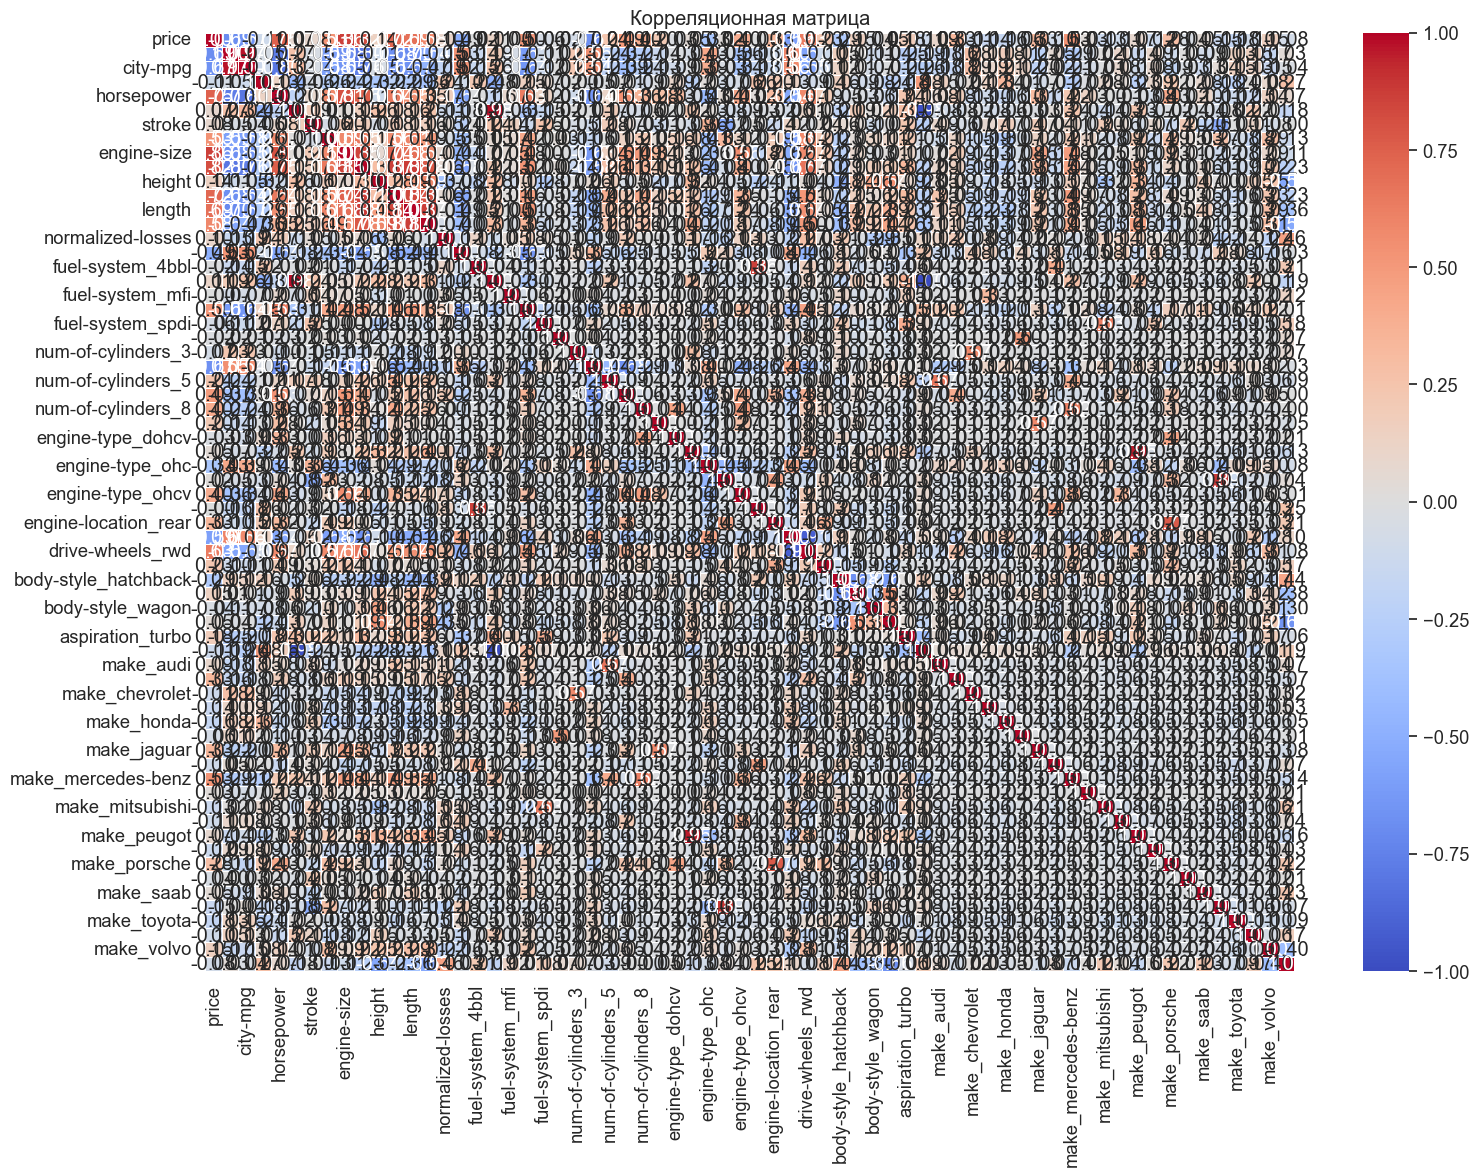

In [30]:
correlation_matrix = pd.concat(
    [
        pd.concat([mm_scaled_x_train, mm_scaled_x_test], axis=0, ignore_index=True),
        pd.concat([y_train, y_test], axis=0, ignore_index=True),
    ],
    axis=1,
).corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()

In [31]:
target_correlations = correlation_matrix["symboling"].drop("symboling")
print("Корреляция признаков с целевой переменной (модуль):")
pprint(target_correlations.abs().sort_values(ascending=False))

Корреляция признаков с целевой переменной (модуль):
num-of-doors_4.0       0.664
height                 0.541
wheel-base             0.532
normalized-losses      0.457
body-style_hatchback   0.436
                        ... 
engine-type_dohcv      0.009
make_mercury           0.009
stroke                 0.005
num-of-cylinders_8     0.004
num-of-cylinders_6     0.000
Name: symboling, Length: 65, dtype: float64


In [32]:
correlation_threshold = 0.2
important_features_target = target_correlations[
    abs(target_correlations) > correlation_threshold
].index.tolist()
print(f"\nВажные признаки (корреляция с целевой переменной > {correlation_threshold}):")
print(*important_features_target, sep="\n")
print(f"Количество признаков изначально: {X_train.shape[1]}")
print(f"Количество важных признаков: {len(important_features_target)}")


Важные признаки (корреляция с целевой переменной > 0.2):
peak-rpm
curb-weight
height
width
length
wheel-base
normalized-losses
fuel-system_4bbl
engine-type_rotor
engine-location_rear
body-style_hatchback
body-style_sedan
body-style_wagon
num-of-doors_4.0
make_mitsubishi
make_porsche
make_saab
make_volvo
Количество признаков изначально: 65
Количество важных признаков: 18


##### Осуществить многоклассовую классификацию с отфильтрованными признаками.

In [33]:
model_knn.fit(mm_scaled_x_train[important_features_target], y_train)
y_pred_important = model_knn.predict(mm_scaled_x_test[important_features_target])

##### Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [34]:
knn_3_imortant_metrics = get_classification_metrics(
    y_test, y_pred_important, "KNN 3 с отобранными признаками", "macro"
)


Метрики для модели: KNN 3 с отобранными признаками
Accuracy: 0.6731
Precision (macro): 0.7238
Recall (macro): 0.7251
F1-score (macro): 0.7240

Classification Report:
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00         1
          -1       0.80      0.80      0.80         5
           0       0.81      0.76      0.79        17
           1       0.57      0.57      0.57        14
           2       0.44      0.50      0.47         8
           3       0.71      0.71      0.71         7

    accuracy                           0.67        52
   macro avg       0.72      0.73      0.72        52
weighted avg       0.68      0.67      0.68        52



##### Сравнить результаты "до" и "после" фильтрации, сделать выводы.

In [35]:
pd.DataFrame(
    [knn_3_metrics, knn_3_imortant_metrics],
    columns=list(knn_3_metrics.keys()),
).drop("classification_report", axis=1)

model_name  accuracy  precision  recall    f1
0                           KNN 3     0.673      0.731   0.655 0.691
1  KNN 3 с отобранными признаками     0.673      0.724   0.725 0.724

**Отбор признаков снизил precision, но accuracy остался прежним, а recall и f1 увеличились**

##### Перебрать значения гиперпараметра $k$ в каком-нибудь диапазоне с использованием кросс-валидации на данных

In [36]:
knn_k_list = range(1, 17)
cv_k = 10
cvgen = StratifiedKFold(cv_k)

for knn_k in tqdm(knn_k_list):
    clf = KNeighborsClassifier(n_neighbors=knn_k)
    scores = cross_val_score(
        clf,
        pd.concat([mm_scaled_x_train, mm_scaled_x_test], axis=0, ignore_index=True)[
            important_features_target
        ],
        pd.concat([y_train, y_test], axis=0, ignore_index=True),
        cv=cvgen,
    )
    print(
        f"Neighbors: {knn_k}, stratified folds count: {cv_k} avg score: {scores.mean()}"
    )

  0%|          | 0/16 [00:00<?, ?it/s]

Neighbors: 1, stratified folds count: 10 avg score: 0.8138095238095238
Neighbors: 2, stratified folds count: 10 avg score: 0.6835714285714286
Neighbors: 3, stratified folds count: 10 avg score: 0.6833333333333333
Neighbors: 4, stratified folds count: 10 avg score: 0.6592857142857143
Neighbors: 5, stratified folds count: 10 avg score: 0.6252380952380953
Neighbors: 6, stratified folds count: 10 avg score: 0.5623809523809523
Neighbors: 7, stratified folds count: 10 avg score: 0.5623809523809524
Neighbors: 8, stratified folds count: 10 avg score: 0.5966666666666666
Neighbors: 9, stratified folds count: 10 avg score: 0.5576190476190476
Neighbors: 10, stratified folds count: 10 avg score: 0.5816666666666668
Neighbors: 11, stratified folds count: 10 avg score: 0.5716666666666667
Neighbors: 12, stratified folds count: 10 avg score: 0.5519047619047618
Neighbors: 13, stratified folds count: 10 avg score: 0.5719047619047619
Neighbors: 14, stratified folds count: 10 avg score: 0.5383333333333333
N

##### Построить график train/test accuracy в зависимости от значения $k$

In [37]:
scores = []
for knn_k in tqdm(knn_k_list):
    clf = KNeighborsClassifier(n_neighbors=knn_k)
    clf.fit(mm_scaled_x_train[important_features_target], y_train)
    train_preds = clf.predict(mm_scaled_x_train[important_features_target])
    test_preds = clf.predict(mm_scaled_x_test[important_features_target])
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    scores.append((knn_k, train_acc, test_acc))

scores_df = pd.DataFrame(scores, columns=["k", "train_acc", "test_acc"])

best_k_value = get_train_test_accuracy_plot(scores_df)
print(f"\nНаилучшее качество при k={best_k_value}")

  0%|          | 0/16 [00:00<?, ?it/s]


Наилучшее качество при k=1


##### Для лучшего классификатора привести метрики, `classification_report`, построить [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) (это вроде матрицы $TN$ / $TP$ / $FN$ / $FP$, только расширенной для многоклассовой классификации, чтобы понять, в какие стороны чаще ошибается классификатор).

In [38]:
best_k_model_knn = KNeighborsClassifier(n_neighbors=best_k_value)
best_k_model_knn.fit(mm_scaled_x_train, y_train)

y_pred_best_k = best_k_model_knn.predict(mm_scaled_x_test)

knn_best_k_metrics = get_classification_metrics(
    y_test, y_pred_best_k, f"KNN {best_k_value}", "macro"
)


Метрики для модели: KNN 1
Accuracy: 0.7500
Precision (macro): 0.6075
Recall (macro): 0.6581
F1-score (macro): 0.6142

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.56      1.00      0.71         5
           0       0.88      0.82      0.85        17
           1       0.90      0.64      0.75        14
           2       0.71      0.62      0.67         8
           3       0.60      0.86      0.71         7

    accuracy                           0.75        52
   macro avg       0.61      0.66      0.61        52
weighted avg       0.77      0.75      0.75        52



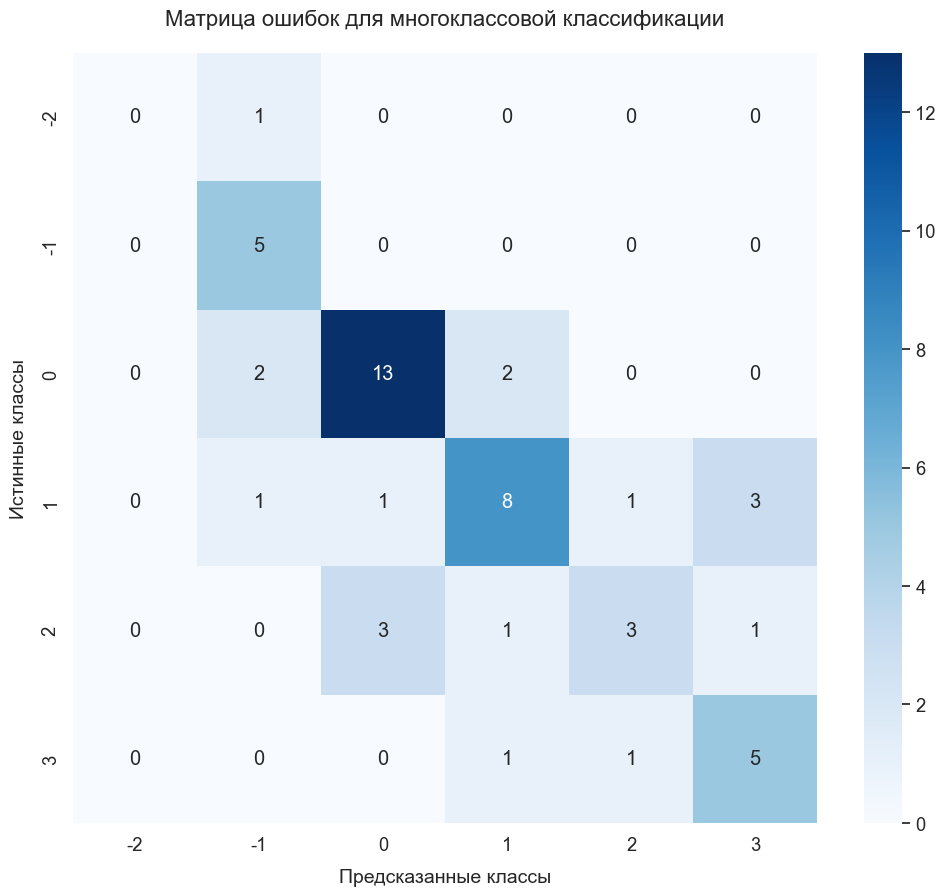

In [39]:
cm = confusion_matrix(y_test, y_pred)

class_labels = sorted(y.unique())

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

plt.xlabel("Предсказанные классы", fontsize=14, labelpad=10)
plt.ylabel("Истинные классы", fontsize=14, labelpad=10)
plt.title("Матрица ошибок для многоклассовой классификации", fontsize=16, pad=20)
plt.show()